In [6]:
def Tracer(aClass):
    class Wrapper:
        def __init__(self, *args, **kargs):
            self.fetches = 0
            self.wrapped = aClass(*args, **kargs)
        def __getattr__(self, attrname):
            print('trace' + attrname)
            self.fetches += 1
            return getattr(self.wrapped, attrname)
    return Wrapper

@Tracer
class Spam:
    def display(self):
        print('spam' * 8)

@Tracer
class Person:
    def __init__(self, name, hours, rate):
        self.name = name
        self.hours = hours
        self.rate = rate
    def pay(self):
        return self.hours*self.rate
    
food = Spam()
food.display()
print([food.fetches])

bob = Person('bob', 40, 50)
print(bob.name)
print(bob.pay())

print("")

sue = Person('sue', rate=100, hours=60)
print(sue.name)
print(sue.pay())

print(bob.name)
print(bob.pay())
print([bob.fetches, sue.fetches])

tracedisplay
spamspamspamspamspamspamspamspam
[1]
tracename
bob
tracepay
2000

tracename
sue
tracepay
6000
tracename
bob
tracepay
2000
[4, 2]


In [1]:
def decorate(func):
    func.marked = True
    return func

@decorate
def spam(a,b):
    return a+b

spam.marked


True

In [3]:
def annotate(text):
    def decorate(func):
        func.label = text
        return func
    return decorate

@annotate('spam data')
def spam(a,b):
    return a+b

spam(1,2), spam.label

(3, 'spam data')

In [13]:
traceMe = False
# traceMe = True
def trace(*args):
    if traceMe:
        print('['+''.join(map(str, args)) + ']')
    
def Private(*privates):
    def onDecorator(aClass):
        class onInstance:
            def __init__(self, *args, **kargs):
                self.wrapped = aClass(*args, **kargs)
            def __getattr__(self, attr):
                trace('get:', attr)
                if attr in privates:
                    raise TypeError('private attribute fetch:'+ attr)
                else:
                    return getattr(self.wrapped, attr)
            def __setattr__(self, attr, value):
                trace('set:', attr, value)
                if attr == 'wrapped':
                    self.__dict__[attr] = value
                elif attr in privates:
                    raise TypeError('private attribute change:'+ attr)
                else:
                    setattr(self.wrapped, attr, value)
        return onInstance
    return onDecorator

if __name__ == "__main__":
    traceMe = True
    @Private('data', 'size')
    class Doubler:
        def __init__(self, label, start):
            self.label = label
            self.data = start
        def size(self):
            return len(self.data)
        def double(self):
            for i in range(self.size()):
                self.data[i] = self.data[i]*2
        def display(self):
            print('{} => {}'.format(self.label, self.data))

x = Doubler('x is', [1,2,3])
y = Doubler('y is', [-10, -20, -30])
print(x.label)
x.display(); x.double(); x.display()
print(y.label)
y.display(); y.double()
y.label = 'spam'
y.display()
# print(x.size())
# print(x.data)
# x.data = [1,1,1]
# x.size = lambda S : 0
# print(y.data)
# print(y.size())




[set:wrapped<__main__.Doubler object at 0x10772fc70>]
[set:wrapped<__main__.Doubler object at 0x107dcadc0>]
[get:label]
x is
[get:display]
x is => [1, 2, 3]
[get:double]
[get:display]
x is => [2, 4, 6]
[get:label]
y is
[get:display]
y is => [-10, -20, -30]
[get:double]
[set:labelspam]
[get:display]
spam => [-20, -40, -60]


In [29]:
trace = True

def rangetest(**argchecks):
    def onDecorator(func):
        if not __debug__:
            return func
        else:
            import sys
            code = func.__code__
            allargs = code.co_varnames[:code.co_argcount]
            funcname = func.__name__
            def onCall (*pargs, **kargs):
                positionals = list(allargs)
                positionals = positionals[:len(pargs)]
                for (argname, (low, high) ) in argchecks.items():
                    if argname in kargs:
                        if kargs[argname] < low or kargs[argname] >high:
                            errmsg = '{} argument "{}" not in {} .. {} '
                            errmsg = errmsg.format(funcname, kargs[argname], low, high)
                            raise TypeError(errmsg)
                    elif argname in positionals:
                        position = positionals.index(argname)        
                        if pargs[position] < low or pargs[position] > high:
                            errmsg = '{} argument "{}" not in {} .. {} '
                            errmsg = errmsg.format(funcname, pargs[position], low, high)
                            raise TypeError(errmsg)
                    else:
                        if trace:
                            print('argument "{}" defaulted '.format(argname))
                return func(*pargs, **kargs)
            return onCall
    return onDecorator

@rangetest(age = (0,120))
def persinfo(name, age):
    print(' {} is {} years old '.format(name, age))

@rangetest(m=(1,12), d=(1,31), y= (0,2009))
def birthday(m, d, y):
    print('birthday = {}/{}/{}'.format(m,d,y))

class Person:
    def __init__(self, name, job, pay):
        self.job = job
        self.pay = pay
    @rangetest(percent=(0.0, 1.0))
    def giveRaise(self, percent):
        self.pay = int(self.pay * (1+percent))

        

persinfo('sue', 24)
birthday(5, d=30, y=1999)



 sue is 24 years old 
birthday = 5/30/1999


In [46]:
def func(a,b,c,d):
    x = 1 
    y = 1 
    z = 1

code = func.__code__
code.co_nlocals
# code.co_varnames
# code.co_argcount

code.co_varnames[:code.co_argcount]

('a', 'b', 'c', 'd')

In [43]:
import sys
# sys.version_info[1]
# 通过判断版本来进行对应的函数调用
# code = func.__code__ if sys.version_info[0] == 3 else func.func_code




9

In [52]:
def rangetest(func):
    def onCall(*pargs, **kargs):
        argchecks = func.__annotations__
        print(argchecks)
        for check in argchecks:
            pass
        return func(*pargs, **kargs)
    return onCall
    

@rangetest
def func(a:(1,5), b, c:(0.0, 1.0)):
    print(a+b+c)

func(3,2,c=3)

{'a': (1, 5), 'c': (0.0, 1.0)}
8


In [64]:
# type(type([]))

# type(list)
type(type)

type

In [68]:
class C:
    pass
x = C()
# type(x)
x.__class__

__main__.C

In [69]:
class Meta(type):
    def __new__(meta, classname, supers, classdict):
        return type.__new__(meta, classname, supers, classdict)
    



In [70]:
class MetaOne(type):
    def __new__(meta, classname, supers, classdict):
        print('in metaone.new:', classname, supers, classdict, sep='...')
        return type.__new__(meta, classname, supers, classdict)

class Eggs:
    pass

print('making class')
class Spam(Eggs, metaclass=MetaOne):
    data = 1
    def meth(self, arg):
        pass

print('making instance')
x = Spam()
print('data:', x.data)


making class
in metaone.new:...Spam...(<class '__main__.Eggs'>,)...{'__module__': '__main__', '__qualname__': 'Spam', 'data': 1, 'meth': <function Spam.meth at 0x10a317790>}
making instance
data: 1


In [72]:
class MetaOne(type):
    def __new__(meta, classname, supers, classdict):
        print('in metaon.new', classname, supers, classdict, sep='...') 
        return type.__new__(meta, classname, supers, classdict)
    def __init__(Class,classname, supers, classdict):
        print('in MetaOne init:', classname, supers, classdict, sep='...')
        print('...init class object:', list(Class.__dict__.keys()))

class Eggs:
    pass

print('making class')
class Spam(Eggs, metaclass=MetaOne):
    data = 1
    def meth(self, arg):
        pass

print('making instance')
x = Spam()
print('data:', x.data)


making class
in metaon.new...Spam...(<class '__main__.Eggs'>,)...{'__module__': '__main__', '__qualname__': 'Spam', 'data': 1, 'meth': <function Spam.meth at 0x10a13d790>}
in MetaOne init:...Spam...(<class '__main__.Eggs'>,)...{'__module__': '__main__', '__qualname__': 'Spam', 'data': 1, 'meth': <function Spam.meth at 0x10a13d790>}
...init class object: ['__module__', 'data', 'meth', '__doc__']
making instance
data: 1


In [75]:
class Client1:
    def __init__(self, value):
        self.value = value
    
    def spam(self):
        return self.value * 2

class Client2:
    value = 'ni?'

def eggsfunc(obj):
    return obj.value * 4

def hamfunc(obj, value):
    return value + 'ham'

Client1.eggs = eggsfunc
Client1.ham = hamfunc    

Client2.eggs = eggsfunc
Client2.ham = hamfunc

x = Client1('ni!')
print(x.spam())
print(x.eggs())
print(x.ham('bacon'))

y = Client2()
print(y.eggs())
print(y.ham('bacon'))



ni!ni!
ni!ni!ni!ni!
baconham
ni?ni?ni?ni?
baconham


In [2]:
def eggsfunc(obj):
    return obj.value*4

def hamfunc(obj, value):
    return value + 'ham'

class Extender(type):
    def __new__(meta, classname, supers, classdict):
        classdict['eggs'] = eggsfunc
        classdict['ham'] = hamfunc
        return type.__new__(meta, classname, supers, classdict)

class Client1(metaclass=Extender):
    def __init__(self, value):
        self.value = value
    def spam(self):
        return self.value * 2

class Client2(metaclass=Extender):
    value = 'ni?'

x = Client1('ni!')
print(x.spam())
print(x.eggs())
print(x.ham('bacon'))

y = Client2()
print(y.eggs())
print(y.ham('bacon'))


ni!ni!
ni!ni!ni!ni!
baconham
ni?ni?ni?ni?
baconham


In [11]:
import eikon as ek
data = ek.get_timeseries('AAPL.O', fields='*', start_date='2021-8-3 16:00:00', end_date='2021-8-3 17:00:00', interval='tick')
# data.info()
# data.tail()


HTTP request failed: 'NoneType' object has no attribute 'http_request'


In [32]:
class Node:
    pass

class Number(Node):
    def __init__(self, value):
        self.value = value

class UnaryOperator(Node):
    def __init__(self, operand):
        self.operand = operand

class BinaryOperator(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOperator):
    pass

class NodeVisitor:
    def visit(self, node):
        methname = 'visit_'+ type(node).__name__
        meth = getattr(self, methname, None)
        if meth is None:
            meth = self.generic_visit
        return meth(node)

    def generic_visit(self, node):
        raise RuntimeError('No {} method'.format('visit_' + type(node).__name__) )

class Evaluator(NodeVisitor):
    def visit_Number(self, node):
        return node.value
    
    def visit_Add(self, node):
        return self.visit(node.left) + self.visit(node.right)

    def visit_Sub(self, node):
        return self.visit(node.left) - self.visit(node.right)

    def visit_Mul(self, node):
        return self.visit(node.left) * self.visit(node.right)

    def visit_Div(self, node):
        return self.visit(node.left) / self.visit(node.right)



class StackCode(NodeVisitor):
    def generate_code(self, node):
        self.instructions = []
        self.visit(node)
        return self.instructions
    
    def visit_Number(self, node):
        self.instructions.append(('PUSH', node.value))

    def binop(self, node, instruction):
        self.visit(node.left)
        self.visit(node.right)
        self.instructions.append((isinstance,))


e = Evaluator()

e.visit(Number(3))
# type(Number(3)).__name__
# type(Number(3))
# Number(3)

3

In [35]:
import types
class Node:
    pass
class NodeVisitor:
    def visit(self, node):
        stack = [node]
        last_result = None
        while stack:
            try:
                last = stack[-1]
                if isinstance(last, types.GeneratorType):
                    stack.append(last.send(last_result))
                    last_result = None
                elif isinstance(last, Node) :
                    stack.append(self._visit(stack.pop()))
                else:
                    last_resutlt = stack.pop()

            except StopIteration :
                stack.pop()
        return last_resutlt

def _visit(self, node):
    methname = 'visit_' + type(node).__name__
    meth = getattr(self, methname, None)
    if meth is None:
        meth = self.generic_visit
    return meth(node)

def generic_visit(self, node):
    raise RuntimeError('No {} method'.format('visit_' + type(node).__name__) )




In [38]:
import logging

a = logging.getLogger('foo')
b = logging.getLogger('bar')
a is b

class Spam:
    def __init__(self, name):
        self.name = name
    
import weakref
_spam_cache = weakref.WeakValueDictionary()
def get_spam(name):
    if name not in _spam_cache:
        s = Spam(name)
        _spam_cache[name] = s
    else:
        s = _spam_cache[name]
    return s

In [46]:
# 解除一个装饰器

from functools import wraps

def decorator1(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print('decorator 1')
        return func(*args, **kwargs)
    return wrapper

def decorator2(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print('decorator 2')
        return func(*args, **kwargs)
    return wrapper

@decorator1
@decorator2
def add(x, y):
    return x + y

# add(2,3)

add.__wrapped__(2,3)


decorator 2


5

In [54]:
# 为类和静态方法提供装饰器
from functools import wraps
import time

def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        r = func(*args, **kwargs)
        end = time.time()
        print(end-start)
        return r
    return wrapper


class Spam:
    @timethis
    def instance_method(self, n):
        print(self, n)
        while n > 0:
            n -= 1

    @classmethod    
    @timethis
    def class_method(cls, n):
        print(cls, n)
        while n>0:
            n -= 1
    
    @staticmethod
    @timethis
    def static_method(n):
        print(n)
        while n > 0:
            n -= 1

s = Spam()
s.instance_method(1000)
# s.class_method(1000)
# s.static_method(1000)

<__main__.Spam object at 0x122c43e20> 1000
0.0007600784301757812


In [60]:
# 装饰器为被包装函数增加参数
from functools import wraps
import inspect

def optional_debug(func):
    if 'debug' in inspect.getargspec(func).args:
        raise TypeError('debug argument already defined')
    
    @wraps(func)
    def wrapper(*args, debug=False, **kwargs):
        if debug:
            print('calling', func.__name__)
        return func(*args, **kwargs)

    sig = inspect.signature(func)
    parms = list(sig.parameters.values())
    parms.append(inspect.Parameter('debug', inspect.Parameter.KEYWORD_ONLY, default=False))
    wrapper.__signature__ = sig.replace(parameters=parms)
    return wrapper

@optional_debug
def add(x,y):
    return x+y

print(inspect.signature(add))

add(2,3)


(x, y, *, debug=False)


/var/folders/sn/qlsq40gd3ggbr4kvwqsblj000000gn/T/ipykernel_21352/125505269.py:6: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if 'debug' in inspect.getargspec(func).args:


5

In [8]:
# 在类上强制使用编程规约
from inspect import signature
import logging

class MatchSignaturesMeta(type):
    def __init__(self, clsname, bases, clsdict):
        super().__init__(clsname, bases, clsdict)
        sup = super(self, self)
        for name, value in clsdict.items():
            if name.startswith('_') or not callable(value):
                print(name, value)
                continue
            prev_dfn = getattr(sup, name, None)
            if prev_dfn:
                prev_sig = signature(prev_dfn)
                val_sig = signature(value)
                if prev_dfn !=val_sig:
                    logging.warning('signature mismatch in %s. %s != %s', value.__qualname__, prev_sig, val_sig)

class Root(metaclass=MatchSignaturesMeta):
    pass

class A(Root):
    def foo(self, x, y):
        pass
    def spam(self, x, *, z):
        pass

class B(A):
    def foo(self, a, b):
        pass
    def spam(self, x, z):
        pass

__module__ __main__
__qualname__ Root
__module__ __main__
__qualname__ A
__module__ __main__
__qualname__ B


In [9]:
class Spam:
    def bar(self, x:int, y:int):
        print('bar1 :', x, y)

    def bar(self, s:int, n:int=0):
        print('bar2 :', s, n)

s = Spam()
s.bar(2,3)
s.bar('hello')


bar2 : 2 3
bar2 : hello 0


In [22]:
#利用函数注解实现方法重载
import inspect
import types

class MultiMethod:

    def __init__(self, name):
        self._methods = {}
        self.__name__ = name
    
    def register(self, meth):
       sig = inspect.signature(meth) 

       types = []
       for name, parm in sig.parameters.items():
           if name == 'self':
                continue
           if parm.annotation is inspect.Parameter.empty:
                raise TypeError('Argument {} must be annotated with a type'.format(name))
           if not isinstance(parm.annotation, type):
                raise TypeError(
                    'Argument {} annotation must be a type'.format(name)
                )
           if parm.default is not inspect.Parameter.empty:
                self._methods[tuple(types)] = meth
           types.append(parm.annotation)

       self._methods[tuple(types)] = meth
def __call__(self, *args):
    types = tuple(type(arg) for arg in args[1:])
    meth = self._methods.get(types, None)
    if meth :
        return meth(*args)
    else:
        raise TypeError('No matching method for types {}'.format(types))




In [29]:
# 避免重复的属性方法
def typed_porperty(name, expected_type):
    stroage_name = '_' + name

    @property
    def prop(self):
        return getattr(self, stroage_name)

    @prop.setter
    def prop(self, value):
        if not isinstance(value, expected_type):
            raise TypeError('{} must be a {}'.format(name, expected_type))
        setattr(self, stroage_name, value)
    return prop


class Person:
    name = typed_porperty('name', str)
    age = typed_porperty('age', int)

    def __init__(self, name, age):
        self.name = name
        self.age = age


a = Person('kkk', 234)

a.name

'kkk'

In [31]:
import dis 

def countdown(n):
    while n>0:
        print('T-minus', n)
        n -= 1
    print('Blastoff!')
        
dis.dis(countdown)

  4     >>    0 LOAD_FAST                0 (n)
              2 LOAD_CONST               1 (0)
              4 COMPARE_OP               4 (>)
              6 POP_JUMP_IF_FALSE       28

  5           8 LOAD_GLOBAL              0 (print)
             10 LOAD_CONST               2 ('T-minus')
             12 LOAD_FAST                0 (n)
             14 CALL_FUNCTION            2
             16 POP_TOP

  6          18 LOAD_FAST                0 (n)
             20 LOAD_CONST               3 (1)
             22 INPLACE_SUBTRACT
             24 STORE_FAST               0 (n)
             26 JUMP_ABSOLUTE            0

  7     >>   28 LOAD_GLOBAL              0 (print)
             30 LOAD_CONST               4 ('Blastoff!')
             32 CALL_FUNCTION            1
             34 POP_TOP
             36 LOAD_CONST               0 (None)
             38 RETURN_VALUE


In [32]:
import time
import imp
import pkgutil
data = pkgutil.get_data(__package__, 'xxx.dat')

imp.reload(time)


<module 'time' (built-in)>

In [35]:
import importlib
time = importlib.import_module("time")
time.time()

1629789592.500841

In [37]:
from urllib import request, parse
url = 'http://httpbin.org/get'
parms = {
   'name1' : 'value1',
   'name2' : 'value2'
}

querystring = parse.urlencode(parms)

# Make a GET request and read the response
u = request.urlopen(url+'?' + querystring)
resp = u.read()
print(resp)

b'{\n  "args": {\n    "name1": "value1", \n    "name2": "value2"\n  }, \n  "headers": {\n    "Accept-Encoding": "identity", \n    "Host": "httpbin.org", \n    "User-Agent": "Python-urllib/3.8", \n    "X-Amzn-Trace-Id": "Root=1-6125a734-227a1a7825fa050b12f0a04c"\n  }, \n  "origin": "104.245.14.31", \n  "url": "http://httpbin.org/get?name1=value1&name2=value2"\n}\n'


In [39]:
from urllib import request, parse

# Base URL being accessed
url = 'http://httpbin.org/post'

# Dictionary of query parameters (if any)
parms = {
   'name1' : 'value1',
   'name2' : 'value2'
}

# Encode the query string
querystring = parse.urlencode(parms)

# Make a POST request and read the response
u = request.urlopen(url, querystring.encode('ascii'))
resp = u.read()
print(resp)

b'{\n  "args": {}, \n  "data": "", \n  "files": {}, \n  "form": {\n    "name1": "value1", \n    "name2": "value2"\n  }, \n  "headers": {\n    "Accept-Encoding": "identity", \n    "Content-Length": "25", \n    "Content-Type": "application/x-www-form-urlencoded", \n    "Host": "httpbin.org", \n    "User-Agent": "Python-urllib/3.8", \n    "X-Amzn-Trace-Id": "Root=1-6125aa06-78837e4e063278a945c4753c"\n  }, \n  "json": null, \n  "origin": "104.245.14.31", \n  "url": "http://httpbin.org/post"\n}\n'


In [1]:
import requests
url = 'http://www.baidu.com'

resp1 = requests.get(url)

resp2 = requests.get(url, cookies=resp1.cookies)
print(resp2)

<Response [200]>


In [5]:
import ipaddress
net = ipaddress.ip_network('123.45.67.64/27')
for a in net:
    print(a)

123.45.67.64
123.45.67.65
123.45.67.66
123.45.67.67
123.45.67.68
123.45.67.69
123.45.67.70
123.45.67.71
123.45.67.72
123.45.67.73
123.45.67.74
123.45.67.75
123.45.67.76
123.45.67.77
123.45.67.78
123.45.67.79
123.45.67.80
123.45.67.81
123.45.67.82
123.45.67.83
123.45.67.84
123.45.67.85
123.45.67.86
123.45.67.87
123.45.67.88
123.45.67.89
123.45.67.90
123.45.67.91
123.45.67.92
123.45.67.93
123.45.67.94
123.45.67.95


In [20]:
import cgi

def notfound_404(environ, start_response):
    start_response('404 Not Found', [ ('Content-type', 'text/plain') ])
    return [b'Not Found']

class PathDispatcher:
    def __init__(self):
        self.pathmap = { }

    def __call__(self, environ, start_response):
        path = environ['PATH_INFO']
        params = cgi.FieldStorage(environ['wsgi.input'],
                                  environ=environ)
        method = environ['REQUEST_METHOD'].lower()
        environ['params'] = { key: params.getvalue(key) for key in params }
        handler = self.pathmap.get((method,path), notfound_404)
        return handler(environ, start_response)

    def register(self, method, path, function):
        self.pathmap[method.lower(), path] = function
        return function



<AxesSubplot:xlabel='Date'>

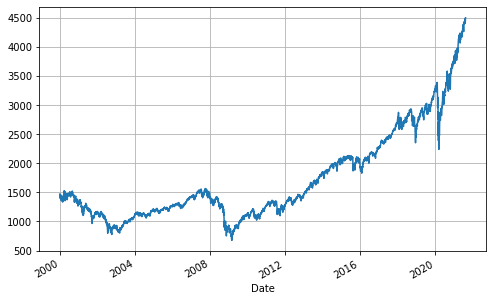

In [19]:
# 量化
import pandas as pd
import numpy as np
from pandas_datareader import data
sp500 = data.DataReader('^GSPC', 'yahoo',start='1/1/2000')
# sp500.head(10)
sp500['Close'].plot(grid=True,figsize=(8,5))


In [33]:
# 一个简单的线程demo
from threading import Thread

def work1(id):
    for i in range(10):
        print(f'第{i} 个 {id}')

def work2():
    for i in range(10):
        print(f'第 {i+1} 个demo')

t1 = Thread(target=work1, args=(234,), name='test1')
t2 = Thread(target=work2, name='test2')

t1.start()
t2.start()

t1.join()
t2.join()

print("*"*10)

第0 个 234
第1 个 234
第2 个 234
第3 个 234
第4 个 234
第5 个 234
第6 个 234
第7 个 234
第8 个 234
第9 个 234
第 1 个demo
第 2 个demo
第 3 个demo
第 4 个demo
第 5 个demo
第 6 个demo
第 7 个demo
第 8 个demo
第 9 个demo
第 10 个demo
**********
